# Recommender systems - Project 3

## Abstract
In this project we evaluate latent factor based recommender system on Movie Lens data set using ALS (Alternating Least Squares factorization method). Once the ratings are factorized, we will use the predicted ratings to propose new movies to some of the users. We will also evaluate the performance of our algorithm using RMSE (Root Mean Squared Error) metric on the test data. This evaluation will eliminate the overfitting problem, and also help us to identify the optimal hyper parameters for the algorithm.

## Data pre-processing
The MovieLens data has several files, but we will use the following files for this project:
1. u.user (a tab delimited data set, containing the users details - users uniquely identified by user_id key)
2. u.item (a tab delimited data set, containing the movie details - movies uniquely identified by item_id)
3. u.data (a tab delimited data set, containing the user_id, item_id and the rating given to the item by the user)

We will choose 10 users randomly from u.user data set, and get all the movies rated by these users (using the u.data). We will confine our data set to only these 10 users, to keep our data simple. The main drawback of limiting ourselves to 10 users is the volume of data available for our training. Since we are training our algorithm using limited data, the performance of our algorithm may be sub-optimal.

### Importing all the required packages

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display # Allows the use of display() for DataFrames
import time
import pickle #To save the objects that were created using webscraping
import pprint
from lxml import html
import requests
#from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import ShuffleSplit
import warnings
import itertools    
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline

### Reading the files 

We will read the u.data, u.user and u.item files, and extract the required columns (since we do not need all the columns for this project). Follow the comments in the code to know which columns are dropped. 

In [2]:
#Reading the movie information
movie_df=pd.read_table("u.item",sep="|" ,header=None)
#display(movie_df.head())
#Selecting only the needed columns: "item_id","item_name" from u.item data set
movie_url = movie_df[[0,1,4]]
movie_url.columns = ["item_id","item_name","item_url"]
movie_df=movie_df[[0,1]]
movie_df.columns = ["item_id","item_name"]

#Displaying sample data
print "Movie data frame sample rows:"
display(movie_df.head())

#Reading the user ID information, and 
#selecting columns: "user_id","age","gender","profession","zip". But we will not use the 
#gender, age, profession, zip
user_df=pd.read_table("u.user",sep="|" ,header=None)
user_df.columns=["user_id","age","gender","profession","zip"]

print "User data frame sample rows:"
display(user_df.head())

#Reading the user, movie ratings information
ratings_df=pd.read_csv("u.data",delimiter = "\t",header=None)
ratings_df.columns = ["user_id",  "item_id","rating","timestamp"]
#Dropping the timestamp info, since we do not need that information in this project
del ratings_df["timestamp"]

print "Displaying the ratings details (mapping between user id and item id):"
display(ratings_df.head())

Movie data frame sample rows:


,item_id,item_name
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


User data frame sample rows:


,user_id,age,gender,profession,zip
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


Displaying the ratings details (mapping between user id and item id):


,user_id,item_id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


### Selecting the users randomly
We will select 10 random users in the following code block. Once the users are selected, we will get the list of all movie names rated by these 10 random users. A data frame is prepared with all the required columns (discarding the unnecessary columns). 

In [3]:
def select_data(user_df, n=10,seed=1234):
    #Selecting only n users randomly
    #Set the seed, to seed to reproduce the same results
    np.random.seed(seed)
    uids = np.random.randint(1,user_df["user_id"].max(),n)

    user_df=user_df.iloc[uids]
    #user_df=user_df[user_df["user_id"].isin(uids)]
    #user_df.index = user_df["user_id"]
    uids = [i+1 for i in uids]
    #print uids
    print "Here are the randomly selected users:\n"
    display(user_df)

    #Combined data frame
    df = pd.merge(pd.merge(user_df,ratings_df),movie_df)
    print "All columns combined:"
    display(df.head())
    #df.sort_values(["item_id"])

    print "The combined data frame has {} rows and {} columns".format(df.shape[0],df.shape[1])
    print "But we will drop 'age', 'gender', 'profession', and 'zip' features, as they are not needed."
    return [df, user_df]

df,user_df = select_data(user_df,n=10,seed=1234)
    


Here are the randomly selected users:



,user_id,age,gender,profession,zip
816,817,19,M,student,60152
724,725,21,M,student,91711
295,296,43,F,administrator,16803
54,55,37,M,programmer,01331
205,206,14,F,student,53115
373,374,36,M,executive,78746
665,666,44,M,administrator,61820
656,657,26,F,none,78704
690,691,34,M,educator,60089
280,281,15,F,student,06059


All columns combined:


,user_id,age,gender,profession,zip,item_id,rating,item_name
0,817,19,M,student,60152,748,4,"Saint, The (1997)"
1,725,21,M,student,91711,748,4,"Saint, The (1997)"
2,206,14,F,student,53115,748,4,"Saint, The (1997)"
3,691,34,M,educator,60089,748,4,"Saint, The (1997)"
4,281,15,F,student,06059,748,5,"Saint, The (1997)"


The combined data frame has 899 rows and 8 columns
But we will drop 'age', 'gender', 'profession', and 'zip' features, as they are not needed.


## Building utility matrix
We will build a utility matrix using the above displayed data frame, after eliminating the unnecessary columns.

In [4]:
df_final = df[["user_id","item_id","rating"]]

#Some users have rated the same movie multiple times. So taking mean of such ratings
df_final = df_final.groupby(["user_id","item_id"]).mean()
df_final = df_final.reset_index()
 
print "We have {} movies rated by the 10 users (randomly selected) in the training data".format(len(set(df_final["item_id"])))

#Building the utility matrix
Utility = df_final.pivot(index="user_id",columns="item_id",values="rating")
#Utility_train = X_train.pivot(index="user_id",columns="item_id",values="rating")
print "Sample data from utility matrix is displayed below. NaNs represent that the user has not rated the movie:"
print "Only some of the initial columns are displayed"

#Utility_train.reset_index(inplace=True)
#Utility_train.reset_index(drop=True,inplace=True)
#print Utility.index.name
Utility.columns.names=[" "]
Utility.iloc[:,range(0,20)]
#utility_matrix = X_train.pivot(index='user_id',columns='item_id',values='rating')

We have 546 movies rated by the 10 users (randomly selected) in the training data
Sample data from utility matrix is displayed below. NaNs represent that the user has not rated the movie:
Only some of the initial columns are displayed


,1,2,4,5,7,8,9,10,11,12,13,14,15,17,19,20,22,23,24,25
user_id,,,,,,,,,,,,,,,,,,,,
55,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN
206,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
281,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
296,5.0,NaN,NaN,NaN,5.0,NaN,4.0,2.0,5.0,NaN,3.0,4.0,3.0,NaN,5.0,5.0,4.0,5.0,2.0,NaN
374,4.0,4.0,2.0,4.0,1.0,NaN,1.0,NaN,4.0,4.0,NaN,NaN,3.0,2.0,NaN,NaN,NaN,3.0,3.0,5.0
657,3.0,NaN,NaN,NaN,3.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
666,NaN,NaN,5.0,2.0,4.0,NaN,NaN,NaN,4.0,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,3.0
691,5.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
725,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN


## Splitting the data into test and train data sets
We will split the data into 20:80 ratio for test:train data. We will first identify the cells in the utility matrix where a movie has been rated by at least 2 users, and randomly pick 20% of such cells as test data. 

This way we can eliminate the chance of picking any movie rated by single user into the test data. So unless a movie has atleast 2 ratings, we will not consider that movie to test our algorithm's performance.

In [5]:
#Define a function that gets the ratings values at the 
#intersection of row_idx and col_idx values, where
#row_idx and col_idx are lists

def get_ratings(Utility,row_idx,col_idx,indices=True):
    '''
       row_idx and col_idx are lists containing the indices of the utility matrix.
       If indices=True, then the row_idx and col_idx represent the actual index value and column name
       else, they represent the row number and column number respectively. 
        
    '''
    ratings = list()
     
    if len(row_idx) == len(col_idx):
        if indices:
            for i in xrange(len(col_idx)):
                ratings.append(Utility.loc[row_idx[i],col_idx[i]])
        else:
            for i in xrange(len(col_idx)):
                ratings.append(Utility.iloc[row_idx[i],col_idx[i]])
        return ratings
    else:
        print "Error. The lengths of the row and col locations must be same"




#What number makes the 20% of the ratings?
#Find the cell locations where there is a true rating.
rows,cols=np.where(~np.isnan(Utility))

#What percentage of cells have the true rating?
nan_perc = 100-100*float(len(cols))/(Utility.shape[0]*Utility.shape[1])
non_nan_perc = 100*float(len(cols))/(Utility.shape[0]*Utility.shape[1])
test_number = np.trunc(0.2 * len(cols))
print "The utility matrix has {}% of NaN values or {}% of available ratings.\n\
Out of the {}% of available ratings, 20% or {} movie ratings of the data will be used for testing".format(nan_perc,
                                                                                      non_nan_perc,non_nan_perc,
                                                                                                         test_number)

ratings_locations = pd.DataFrame(zip(rows,cols),columns = ["row","column"])
#print ratings_locations

ratings_counts = ratings_locations.groupby(["column"])['row'].count()
#print ratings_counts
cols_num_2_ratings = list(ratings_counts[ratings_counts>1].index)
#cols_num_2_ratings contains the column number in the Utility, where there are 
#at least 2 ratings
#print Utility.columns[np.where(~np.isnan(Utility.iloc[:,cols_num_2_ratings[0]]))][0]

#print Utility.iloc[:,cols_num_2_ratings]
test_row_num = list()
test_col_num = list()

#for i in movies_ids_more_than_2_ratings:
#    test_row_pos.append(np.where(~np.isnan(Utility.loc[:,i])))
sample_count = 0
#print cols_num_2_ratings
#print movies_ids_more_than_2_ratings
#print Utility.columns[np.where(~np.isnan(Utility.iloc[:,cols_num_2_ratings[0]]))][0]

train_df = Utility.copy()

for i in cols_num_2_ratings:
    #print Utility.columns[np.where(~np.isnan(Utility.iloc[:,i]))]
    #test_row_num.append(Utility.columns[np.where(~np.isnan(Utility.iloc[:,i]))][0])
    test_row_num.append(np.where(~np.isnan(Utility.iloc[:,i]))[0][0])
    test_col_num.append(i)
    sample_count = sample_count + 1
    train_df.iloc[test_row_num[-1],test_col_num[-1]] = np.nan
    if sample_count >= test_number:
        break

        
test_ratings=get_ratings(Utility,test_row_num,test_col_num,indices=False)

user_id = [Utility.index[i] for i in test_row_num]
item_id = [Utility.columns[i] for i in test_col_num]

test_df = pd.DataFrame(zip(test_row_num,test_col_num,
                           user_id,
                           item_id,
                           test_ratings),columns=["row_number","column_number","user_id","item_id","rating"])


#print test_df

#print Utility.iloc[3,0]
#print Utility.iloc[4,3]

#print train_df.iloc[3,0]
#print train_df.iloc[4,3]

print "\n\nDisplaying the training data and the Utility matrices. Note that some cells in the training data are made NA"
print "\n\nTraining data"
display(train_df)
print "Utility data"
display(Utility)
print "You can see that the for 296 user and for movie ID 1, the training data has NA value, \
while the \nutility matrix has a genuine value. This confirms that we successfully masked \
the ratings belonging to test data in  the training data" 





The utility matrix has 83.5347985348% of NaN values or 16.4652014652% of available ratings.
Out of the 16.4652014652% of available ratings, 20% or 179.0 movie ratings of the data will be used for testing


Displaying the training data and the Utility matrices. Note that some cells in the training data are made NA


Training data


,1,2,4,5,7,8,9,10,11,12,...,1407,1429,1430,1431,1432,1433,1434,1451,1474,1513
user_id,,,,,,,,,,,,,,,,,,,,,
55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
206,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN
281,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
296,NaN,NaN,NaN,NaN,5.0,NaN,NaN,2.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
374,4.0,4.0,NaN,NaN,1.0,NaN,1.0,NaN,4.0,NaN,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
657,3.0,NaN,NaN,NaN,3.0,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
666,NaN,NaN,5.0,2.0,4.0,NaN,NaN,NaN,4.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,NaN
691,5.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
725,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Utility data


,1,2,4,5,7,8,9,10,11,12,...,1407,1429,1430,1431,1432,1433,1434,1451,1474,1513
user_id,,,,,,,,,,,,,,,,,,,,,
55,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
206,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN
281,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
296,5.0,NaN,NaN,NaN,5.0,NaN,4.0,2.0,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
374,4.0,4.0,2.0,4.0,1.0,NaN,1.0,NaN,4.0,4.0,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
657,3.0,NaN,NaN,NaN,3.0,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
666,NaN,NaN,5.0,2.0,4.0,NaN,NaN,NaN,4.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,NaN
691,5.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
725,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


You can see that the for 296 user and for movie ID 1, the training data has NA value, while the 
utility matrix has a genuine value. This confirms that we successfully masked the ratings belonging to test data in  the training data


## Implementing alternating least squares method for matrix factorization

We will use alternating least squares method for matrix factorization. We assume that the utility matrix is named as M, with _n_ rows and _m_ columns. This means that the utility matrix has _n_ users and _m_ items (or movies). This matrix will be decomposed into U and V matrices with _nXd_ and _dXm_ dimensions respectively, where _d_ is the desired number of latent factors. 
To decompose the Utility matrix _M_ into _UxV_ we will use the python functions defined below:


### Function definitions

*normalize(M):* This function takes numpy matrix M as input and normalizes the matrix's data using the following logic:
1. For each row, get the respective mean (ignoring the NANs).
2. Subtract the means obtained in step-1 from the respective rows
3. Get the means of the columns of the modified matrix from step-2
4. Subtract the column means from the respective columns of the modified matrix, obtained in step-2

*build_U(M,U,V,r,s,reg):* This function optimizes the U matrix's element at row _r_ and column _s_. The _reg_ is the regularization parameter, _M, U, V_ are the normalized utility matrix, U matrix and V matrix respectively. Returns the optimal value of U's element for [r,s] location

*build_V(M,U,V,r,s,reg):* This function optimizes the V matrix's element at row _r_ and column _s_. The _reg_ is the regularization parameter, _M, U, V_ are the normalized utility matrix, U matrix and V matrix respectively. Returns the optimal value of V's element for [r,s] location

*get_error(M,U,V):* Computes the RMSE between M and UV (without considering the NA values in M)

*list_mean(l):* Gets the mean of input numpy array, without considering the NA values

*get_U_V(Utility,factors,reg, episodes, test_df,seed):* Main function that takes the Utility data frame, required number of factors, regularization parm, number of times to train all the elements of U and V matrices, the test data frame, and the seed for reproducible results. The function outputs 6 values: _U, V, training errors, test errors, item means and user means_

*get_ratings(Utility,row_idx,col_idx,indices=True):* Gets the rating at the specific row and column locations in the Utility data frame. The row_idx and col_idx can be index and column names or they can be row number and column number. If they represent the index and column, then the indices parameter must be set to True, else it must be set to False.

In [6]:
## Build U function:
def build_U(M,U,V,r,s,reg):
    #Function to compute the U[r,s] entry
    
    #Get the s row from V
    V_s=V[s,:].copy()
    #Get the r row from M
    M_r=M[r,:].copy()
    
    #Get the r row from U
    U_r = U[r,:].copy()
    U_r[s] = 0
    #Get the r col from V
    V_r = V[:,r].copy()
    V_r[s] = 0
    #print "V_s:{}".format(V_s)
    #print "M_r:{}".format(M_r)
    #print "U_r:{}".format(U_r)
    #print "V_r:{}".format(V_r)
    M_r = M_r - np.dot(U_r,V_r)
    V_s[np.isnan(M_r)] = 0
    M_r[np.isnan(M_r)] = 0
    
    #print "M_r:{}".format(M_r)
    return np.dot(V_s,M_r)/(np.dot(V_s,V_s) + reg)

## Build V function:
def build_V(M,U,V,r,s,reg):
    #Get the r col from U
    U_r=U[:,r].copy()
    #Get the s col from M
    M_s=M[:,s].copy()
        
    #Get the s col from V
    V_s = V[:,s].copy()
    V_s[r] = 0
    #Get the s row from U
    U_s = U[r,:].copy()
    U_s[r] = 0
    #print "V_s:{}".format(V_s)
    #print "M_s:{}".format(M_s)
    #print "U_r:{}".format(U_r)
    #print "U_s:{}".format(U_s)
    M_s = M_s - np.dot(V_s,U_s)
    U_r[np.isnan(M_s)] = 0
    M_s[np.isnan(M_s)] = 0
    
    #print "M_s:{}".format(M_s)
     
    return np.dot(U_r,M_s)/(np.dot(U_r,U_r) + reg)

#Get the error
def get_error(M,U,V):
    return np.sqrt(np.nanmean(np.square(M - np.dot(U,V))))

##Normalize the Utility matrix:
##Subtract the avg user rating and avg item rating from the item in M
#print M
def list_mean(l):
    return np.nanmean(l)

def normalize(M):
    #Convert M to a numpy array
    #print "In normalize"
    M = np.array(M)
    
    #Get the column means (or items mean)
    items_mean=np.apply_along_axis(list_mean,0,M)
    
    #If an item is NOT rated by any user, then we will get NA fr mean
    #So for such instances, fill the mean item ratings with 0
    #Such scenario may arise if only one user has rated a movie,
    #and if that instance is included in the test data.
    #items_mean = np.nan_to_num(items_mean)
    #items_mean[np.where(np.isnan(items_mean))] = np.nanmean(M)
    #print "In normalize items mean"
    #print items_mean
    if np.isnan(np.sum(items_mean)):
        print "WARNING: Items has NAN values. which is incorrect"
    #print "items related nan.{}".format(np.isnan(np.sum(items_mean)))
    #print np.where(np.isnan(items_mean))
    #print M[:,20]
    #print len(items_mean)
    
    #Subtract the columns mean from the respective columns
    M_normalized = M[:,] - items_mean
    
    #Get the rows means (or users mean) using the partially normalized matrix
    users_mean = np.apply_along_axis(list_mean,1,M_normalized)
    #print "users related nan.{}".format(np.isnan(np.sum(users_mean)))
    #print "In normalize users mean"
    #print np.isnan(np.sum(users_mean))
    #print len(users_mean)
    #Subtract the rows means
    M_normalized = (M_normalized[:,].T- users_mean)
    
    #Transform back
    return [M_normalized.T, items_mean, users_mean]

##Main function that performs the UV decomposition
def get_U_V(Utility,factors,reg, episodes, test_df,seed):
    #Input the Utility Matrix as it is. The normalizationprocess happens in this function
    #factors controls the desired number of latent factors
    #reg controls the regularization
    #episodes control the number of times to visit each elements of U and V
    #test_df has the test data
    
    #Normalize the Utility matrix
    M,items_mean,users_mean = normalize(Utility)
    #code to check if any element has NaN 
    #print np.isnan(np.sum(items_mean))
    #print np.isnan(np.sum(users_mean))
    M_rows,M_cols = M.shape
    
    
    
    #Define U and V matrices, and initialize them to 0
    #U = np.ones((M_rows,factors),dtype=np.float)
    #V = np.ones((factors,M_cols),dtype=np.float)
    
    np.random.seed(seed)
    U = np.zeros((M_rows,factors),dtype=np.float)+np.random.rand(M_rows,factors)
    #U = np.zeros((M_rows,factors),dtype=np.float)+.2
    #print U
    np.random.seed(seed)
    V = np.zeros((factors,M_cols),dtype=np.float)+np.random.rand(factors,M_cols)
    #V = np.zeros((factors,M_cols),dtype=np.float)+.2
    
    #Define the lists to hold training and test errors
    training_error = list()
    test_error = list()
    
    #Compute the initial training error
    training_error.append(get_error(M,U,V))
    
    #Prepare list of indices in U and V, to fix one element of 
    #U and V at a time. We will use the sequence:
    #U[0,0] V[0,0] U[0,1] V[0,1] ...
    U_iterator = list(itertools.product(xrange(M_rows),xrange(factors)))
    V_iterator = list(itertools.product(xrange(factors),xrange(M_cols)))
    U_len = len(U_iterator)
    V_len = len(V_iterator)
    
    #max elements to check if we processed all the elements of U and V
    max_elements = U_len + V_len
    
    #Repeat the loop for the episodes number of times
    for episode in xrange(episodes):
        #print "episode:{}, error:{}".format(episode,training_error[-1])
        counter = 0
        while counter <= max_elements:
            r,s = U_iterator[counter % U_len]
            U[r,s] = build_U(M,U,V,r,s,reg)
            training_error.append(get_error(M,U,V))
            r,s = V_iterator[counter % V_len]
            V[r,s] = build_V(M,U,V,r,s,reg)
            training_error.append(get_error(M,U,V))
            counter=counter+1
        temp_UV = np.dot(U,V) + items_mean
        temp_UV = temp_UV.T + users_mean
        temp_UV = temp_UV.T
        #print temp_UV
        #print "temp_UV NAN Check. Got {}".format(np.isnan(np.sum(temp_UV)))
        predicted_ratings = get_ratings(pd.DataFrame(temp_UV),list(test_df["row_number"]),
                                               list(test_df["column_number"]),indices=False) 
        test_error.append(np.nanmean(np.square(np.array(test_df["rating"]) - np.array(predicted_ratings))))
        #print "predicted ratings NAN Check. Got {}".format(np.isnan(np.sum(predicted_ratings)))
        #print "predicted ratings:{}".format(predicted_ratings)
        predicted_df = test_df.copy()
        predicted_df["predicted"] = predicted_ratings
        #print predicted_df
        #print temp_UV
    return [U,V,training_error,test_error,predicted_df,items_mean, users_mean]



## Training and evaluation

We will train (or decompose the training data) into U and V. In the process of decomposition, we will also collect the training and test errors (test error is obtained by obtaining the RMSE using the test data). We will run the algorithm for 10 episodes. Each episode visits all the elements in the U and V at least once and optimizes the elements. The elements are also visited in a specific fashion (the first row elements of U matrix are tuned first, followed by the first row of V matrix and so on). This process is repeated for the required number of episodes. We will also estimate the training error and test error for different values of the regularization parameter and the latent factors as given below:

$$d = \mbox{Number of latent factors}=\{2,3,4\}$$
$$reg = \mbox{Regularization parameter} = \{2,3,4\}$$

The matrices U and V are initialized by randomly choosing the values from standard normal distribution (mean 0 and variance of 1)

In [7]:
d = [2,3,4]
reg=[2,3,4]
#d = [2]
#reg=[2]

best_training_error=[]
best_test_error=[]
best_episode=[]
for i in d:
    for j in reg:
        #print "Using Latent factor={} and reg={}".format(i,j)
        
        U,V,training_error,test_error,predicted_df,items_mean, users_mean = get_U_V(train_df,i,j, 4, test_df,1)
        best_training_error.append([i,j,np.min(training_error)])
        best_episode=np.where(np.sqrt(test_error)==np.min(np.sqrt(test_error)))[0][0]
        best_test_error.append([i,j,best_episode,np.min(np.sqrt(test_error))])
        #print "Least possible training error:{}".format(np.min(training_error))
        #print "Least possible test error:{}".format(np.min(np.sqrt(test_error)))


In [8]:
display_df=pd.DataFrame(best_test_error,columns=["Latent Factors count","Reg parm","best_episode","Error"])
display_df.sort("Error")

,Latent Factors count,Reg parm,best_episode,Error
8,4,4,1,1.250163
2,2,4,2,1.251916
5,3,4,1,1.252090
1,2,3,1,1.253327
7,4,3,1,1.254466
6,4,2,2,1.259663
4,3,3,1,1.261190
3,3,2,0,1.268798
0,2,2,3,1.269283


From the above display (sorted in the descending order of _test_ error), we can observe that for 4 latent factors, we have the minimum error. But for 2 latent factors also the error is not significantly different than the 4 latent factors error. Hence we will consider the latent factors = 2, reg parm = 4 and train for 2 episodes. With 2 latent factors, we can easily visualize the data.

The following code block will use reg=4, episodes=2, and latent factors = 2, to get the U and V matrices. We will also get the genre of each movie in this code block. The genre will be used later, when we evaluate our recommender system.

In [9]:
U,V,training_error,test_error,predicted_df,items_mean,users_mean = get_U_V(train_df,2,4, 2, test_df,1)

#Covnert V to a data frame
V_df=pd.DataFrame(V,columns=list(train_df.columns))
V_df = V_df.T
V_df.columns = ["Factor-1","Factor-2"]
V_df=V_df.reset_index()

V_df.columns = ["item_id","Factor-1","Factor-2"]

#print train_df.loc[:,1]
#Get the genere
items_df=pd.read_table("u.item",sep="|" ,header=None)

items_df.columns=["item_id","item_name","release_date","video_release_date","IMDb_URL",
"unknown","Action","Adventure","Animation","Childrens","Comedy","Crime",
                  "Documentary","Drama","Fantasy","Film-Noir",
                  "Horror","Musical","Mystery","Romance","Sci-Fi","Thriller","War","Western"]

items_df = items_df[["item_id","item_name",
                     "unknown","Action","Adventure",
                     "Animation","Childrens","Comedy",
                     "Crime","Documentary","Drama","Fantasy",
                     "Film-Noir","Horror","Musical",
                     "Mystery","Romance","Sci-Fi",
                     "Thriller","War","Western"]]

all_movies_genre = pd.melt(items_df,id_vars=["item_id","item_name"],value_vars=["unknown","Action","Adventure",
                     "Animation","Childrens","Comedy",
                     "Crime","Documentary","Drama","Fantasy",
                     "Film-Noir","Horror","Musical",
                     "Mystery","Romance","Sci-Fi",
                     "Thriller","War","Western"])
all_movies_genre = all_movies_genre[all_movies_genre["value"] != 0]

all_movies_genre=all_movies_genre.groupby(['item_id','item_name']).agg(lambda x: ' '.join(set(x)))
all_movies_genre=all_movies_genre.reset_index()
all_movies_genre.columns=["item_id","item_name","Genre"]

print "Some movies and their genres. A move can belong to more than one genre."
display(all_movies_genre.head())



Some movies and their genres. A move can belong to more than one genre.


,item_id,item_name,Genre
0,1,Toy Story (1995),Comedy Animation Childrens
1,2,GoldenEye (1995),Action Adventure Thriller
2,3,Four Rooms (1995),Thriller
3,4,Get Shorty (1995),Action Drama Comedy
4,5,Copycat (1995),Drama Thriller Crime


### Get the UV matrix
The following code block will get the UV matrix (converted to a data frame). It will have the same shape and columns as the Utility matrix. The UV matrix will have the predicted ratings of all the users (randomly selected).

In [10]:
#display(pd.DataFrame(U))
#display(pd.DataFrame(V))
UV = pd.DataFrame(np.dot(U,V))
UV = UV + items_mean
UV = UV.T + users_mean
UV = UV.T

UV.index=Utility.index
UV.columns=Utility.columns
print "The UV matrix is displayed below. It has the predicted ratings for all the 10 users"
display(UV.head(10))


The UV matrix is displayed below. It has the predicted ratings for all the 10 users


,1,2,4,5,7,8,9,10,11,12,...,1407,1429,1430,1431,1432,1433,1434,1451,1474,1513
user_id,,,,,,,,,,,,,,,,,,,,,
55,3.750731,3.749381,4.751311,1.751311,3.211622,1.750103,2.794497,1.748447,3.750430,3.751311,...,1.749388,0.750025,0.750025,0.750025,0.750025,0.750025,0.750026,2.751302,2.751302,1.749388
206,3.905399,3.904472,4.904698,1.904698,3.313469,1.904566,2.908951,1.904163,3.904598,3.904701,...,1.904407,0.904553,0.904553,0.904553,0.904553,0.904553,0.904553,2.904830,2.904830,1.904407
281,4.019055,4.027667,5.025877,2.025877,3.353532,2.026905,2.993485,2.030447,4.026659,4.025845,...,2.028288,1.027020,1.027020,1.027020,1.027020,1.027020,1.027020,3.024607,3.024607,2.028289
296,4.244047,4.186870,5.196358,2.196358,4.005548,2.191051,3.356065,2.169135,4.192268,4.196574,...,2.182592,1.190373,1.190373,1.190373,1.190373,1.190373,1.190377,3.205092,3.205092,2.182588
374,3.895820,3.985092,4.951288,1.951288,2.148648,1.971628,2.263246,2.018520,3.966413,3.951010,...,1.990571,0.973377,0.973377,0.973377,0.973377,0.973377,0.973362,2.940049,2.940049,1.990575
657,3.850062,3.888417,4.886635,1.886635,3.148194,1.887287,2.885369,1.898929,3.887270,3.886476,...,1.891577,0.887575,0.887575,0.887575,0.887575,0.887575,0.887574,2.880198,2.880198,1.891580
666,3.999977,3.933642,4.959244,1.959244,4.267248,1.943823,3.481680,1.908656,3.947783,3.959449,...,1.929601,0.942506,0.942506,0.942506,0.942506,0.942506,0.942518,2.967535,2.967535,1.929598
691,4.106404,4.112501,5.111708,2.111708,3.474578,2.112135,3.099739,2.114326,4.112044,4.111685,...,2.112971,1.112199,1.112199,1.112199,1.112199,1.112199,1.112199,3.110749,3.110749,2.112971
725,4.267847,4.258599,5.259997,2.259997,3.722102,2.259225,3.282655,2.255772,4.259398,4.260032,...,2.257899,1.259121,1.259121,1.259121,1.259121,1.259121,1.259121,3.261426,3.261426,2.257898


### Getting recommendations
We will now get the recommendations for some of the users, based on the movies they rated. We assume that a user has liked the movie, if he has rated that movie with more than 4 stars. For our convnience, we will define a function that accepts the user ID, along with the number of desired recommended movies, the Utility matrix, the transposed V matrix (converted to a data frame, with rows corresponding to the movies, and columns corresponding to the factors), and all movie genres data frame. 

In [11]:
def get_recommendations(user_id,n,U,V_df,all_movies_genre):
        #Get all the movies rated by user ID 
        user_rated = Utility.loc[user_id][Utility.loc[user_id].notnull()]    
        #Get all the ratings of the user having more than 4    
        user_high_rated_df = all_movies_genre[all_movies_genre["item_id"].isin( \
        user_rated[user_rated.values >= 4].index)]
        user_V_df = V_df[V_df["item_id"].isin(user_rated.index)]
        
        user_watched= pd.merge(user_V_df,user_high_rated_df,on="item_id")
        user_watched["watched"] = "Yes"

        
        user_UV = UV.loc[user_id].copy()
        user_UV[user_rated.index] = -1
        recommended_movie_ids =  user_UV.sort_values(ascending=False).index[0:n]
        recommended_movies_df = V_df[V_df["item_id"].isin(recommended_movie_ids)]

        recommended_movies_df=pd.merge(recommended_movies_df,
         all_movies_genre[all_movies_genre["item_id"].isin(recommended_movie_ids)],
         on="item_id")
        recommended_movies_df["watched"] = "No"

        print "The following movies were liked by user ID:{}, since s/he gave a rating of 4 or more\
         for these movies:".format(user_id)
        display(user_watched)
        print "The following movies are recommended to user ID:{}".format(user_id)
        display(recommended_movies_df)
        plot_df = pd.concat([user_watched,recommended_movies_df])
        #display(plot_df)
        #fig, ax = plt.subplots()
        #for dd,daata in plot_df.groupby('watched'):
        #     ax.plot(daata['Factor-1']*100,daata['Factor-2']*100,'o',alpha=0.3)
        import seaborn as sns
        sns.set(style="ticks", context="talk")
        # Make a custom sequential palette using the cubehelix system
        #pal = sns.cubehelix_palette(20, 1, 1, light=.4, dark=.6)
        pal= sns.color_palette("husl", 2)
         
        sns.lmplot(x="Factor-1",y="Factor-2",fit_reg=False,hue="watched",
           palette=pal,data=plot_df,size=10,scatter_kws={'alpha':0.3})
         
        plt.show()
        return plot_df



We have chosen the following User IDs randomly.

In [12]:
display(user_df)

,user_id,age,gender,profession,zip
816,817,19,M,student,60152
724,725,21,M,student,91711
295,296,43,F,administrator,16803
54,55,37,M,programmer,01331
205,206,14,F,student,53115
373,374,36,M,executive,78746
665,666,44,M,administrator,61820
656,657,26,F,none,78704
690,691,34,M,educator,60089
280,281,15,F,student,06059


Let us get the 10 recommended movies for the users 206 and 55.

The following movies were liked by user ID:206, since s/he gave a rating of 4 or more         for these movies:


,item_id,Factor-1,Factor-2,item_name,Genre,watched
0,258,-0.189225,-0.340196,Contact (1997),Drama Sci-Fi,Yes
1,269,0.000095,0.027402,"Full Monty, The (1997)",Comedy,Yes
2,272,0.004697,0.021990,Good Will Hunting (1997),Drama,Yes
3,288,0.160959,0.109175,Scream (1996),Horror Thriller,Yes
4,302,-0.323860,-0.239346,L.A. Confidential (1997),Mystery Thriller Film-Noir Crime,Yes
5,310,-0.009184,-0.026397,"Rainmaker, The (1997)",Drama,Yes
6,313,0.009472,0.030513,Titanic (1997),Action Drama Romance,Yes
7,315,0.009472,0.030513,Apt Pupil (1998),Drama Thriller,Yes
8,333,0.083121,-0.002549,"Game, The (1997)",Mystery Thriller,Yes
9,346,0.007481,0.016144,Jackie Brown (1997),Drama Crime,Yes


The following movies are recommended to user ID:206


,item_id,Factor-1,Factor-2,item_name,Genre,watched
0,318,-0.011426,-0.007041,Schindler's List (1993),Drama War,No
1,529,-0.011754,-0.006364,My Life as a Dog (Mitt liv som hund) (1985),Drama,No
2,613,-0.012308,-0.007384,My Man Godfrey (1936),Comedy,No
3,642,-0.012311,-0.007386,"Grifters, The (1990)",Drama Film-Noir Crime,No
4,647,-0.012311,-0.007386,Ran (1985),Drama War,No
5,651,-0.012311,-0.007386,Glory (1989),Action Drama War,No
6,707,-0.012437,-0.008303,Enchanted April (1991),Drama,No
7,856,-0.012772,-0.008887,Night on Earth (1991),Drama Comedy,No
8,1021,-0.013206,-0.009693,8 1/2 (1963),Drama,No
9,1266,-0.013240,-0.010314,Bread and Chocolate (Pane e cioccolata) (1973),Drama,No


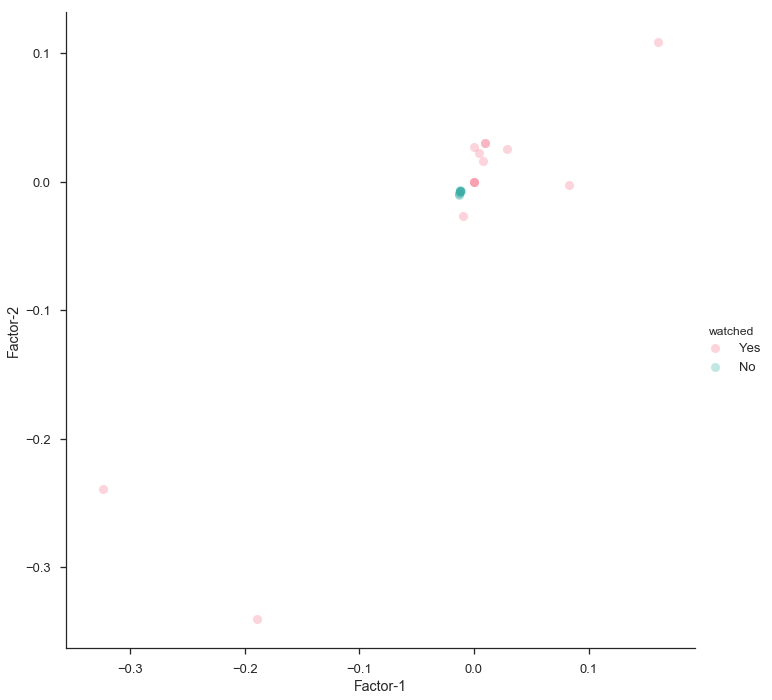

In [13]:
recommendations=get_recommendations(206,10,U,V_df,all_movies_genre)

From the above display we can infer that the recommended movies (blue dots) are really close to each other and are nearer to the most of the cluster of movies which were rated high by the user 206.

Let us get the top 10 recommendations for the user ID 55

The following movies were liked by user ID:55, since s/he gave a rating of 4 or more         for these movies:


,item_id,Factor-1,Factor-2,item_name,Genre,watched
0,22,0.020607,0.015494,Braveheart (1995),Action Drama War,Yes
1,50,-0.001654,-0.104345,Star Wars (1977),Action Romance War Adventure Sci-Fi,Yes
2,56,0.033749,-0.013568,Pulp Fiction (1994),Drama Crime,Yes
3,79,0.044581,0.031531,"Fugitive, The (1993)",Action Thriller,Yes
4,89,-0.102633,-0.151662,Blade Runner (1982),Sci-Fi Film-Noir,Yes
5,118,0.022760,-0.079845,Twister (1996),Action Adventure Thriller,Yes
6,144,0.110393,0.058067,Die Hard (1988),Action Thriller,Yes
7,174,0.138997,0.050010,Raiders of the Lost Ark (1981),Action Adventure,Yes
8,181,0.029083,-0.135606,Return of the Jedi (1983),Action Romance War Adventure Sci-Fi,Yes
9,273,-0.141512,-0.042324,Heat (1995),Action Thriller Crime,Yes


The following movies are recommended to user ID:55


,item_id,Factor-1,Factor-2,item_name,Genre,watched
0,4,-0.013263,-0.000371,Get Shorty (1995),Action Drama Comedy,No
1,529,-0.011754,-0.006364,My Life as a Dog (Mitt liv som hund) (1985),Drama,No
2,613,-0.012308,-0.007384,My Man Godfrey (1936),Comedy,No
3,642,-0.012311,-0.007386,"Grifters, The (1990)",Drama Film-Noir Crime,No
4,647,-0.012311,-0.007386,Ran (1985),Drama War,No
5,651,-0.012311,-0.007386,Glory (1989),Action Drama War,No
6,707,-0.012437,-0.008303,Enchanted April (1991),Drama,No
7,856,-0.012772,-0.008887,Night on Earth (1991),Drama Comedy,No
8,1021,-0.013206,-0.009693,8 1/2 (1963),Drama,No
9,1266,-0.013240,-0.010314,Bread and Chocolate (Pane e cioccolata) (1973),Drama,No


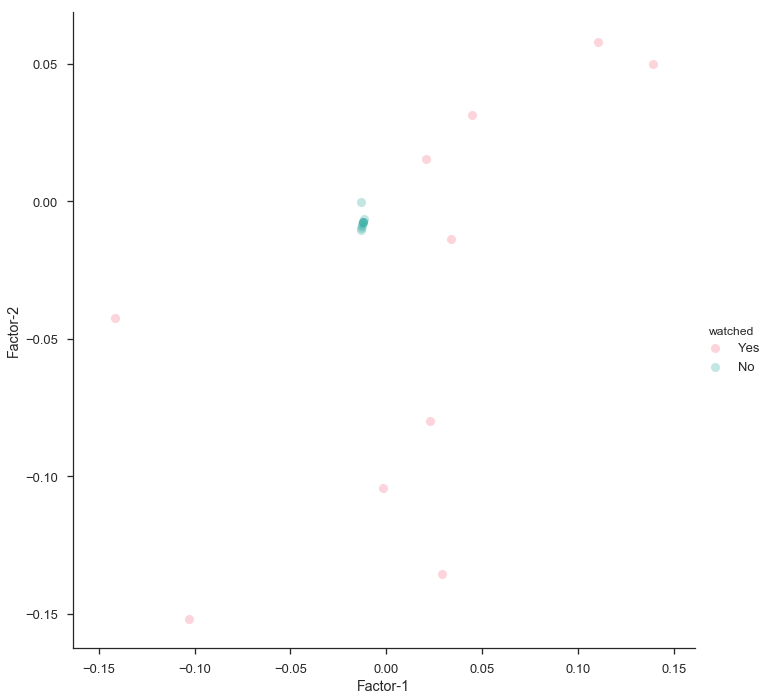

In [14]:
recommendations=get_recommendations(55,10,U,V_df,all_movies_genre)

From the above display, we can infer that the user ID 55 has liked movies from different genres, and hence the recommended movies are around the center of all the movies liked by user ID 55.

## Conclusion

In this project, we evaluated the alternating least squares method to factorize the utility matrix, and evaluated the algorithm's performance on the test data. One of the drawbacks of the algorithm's implementation is related to finding the optimal value for each value of U and V. We were not able to use matrix operations to perform this computation. As a part of future work we will perform the matrix factorization method using the Stochastic gradient descent method. The stochastic gradient descent method can exploit the vector level operations to compute the best factors for the Utility matrix. Another drawback of this project is the amount of data we considered. We considered data related to just 10 random users. This limits the algorithm's performance from the prediction point of view. Our test RMSE error is approximately 1.25, which is significantly high. But when we trained our algorithm using 200 random users (not included in this document), we were able to reduce the RMSE error to less than 1.15 (which is still high), but considerably lesser error, when compared to the data with just 10 random users.

We visually evaluated the recommendations, and found that the recommendations are approximately clustered around the mid point of the movies, which are rated high by the user. 

### References:
1. F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets:
History and Context. ACM Transactions on Interactive Intelligent
Systems (TiiS) 5, 4, Article 19 (December 2015), 19 pages.
DOI=http://dx.doi.org/10.1145/2827872

2. Jure Leskovec, Anand Rajaraman and Jeffrey D. Ullman 2014. Mining of Massive Datasets (Chapter 9)